# **Central bank communication & information overload: an empirical analysis of fed speeches and market reactions**

<u><strong>Author:</strong></u> Anaïs Augé & Alexandre Nonnenmacher

<u><strong>Course:</strong></u> Machine learning for Portfolio Management and Trading

<u><strong>Date:</strong></u> November 14, 2025


### **Setup and dependencies**

This notebook requires several Python packages. The following cells ensures all necessary libraries are installed and imported.

In [80]:
import sys
import subprocess
import pkg_resources
import importlib

# Mapping to handle pip-name vs import-name differences
PACKAGE_MAP = {
    "sentence-transformers": "sentence_transformers",
    "beautifulsoup4": "bs4",
    "sklearn": "sklearn",
    "statsmodels": "statsmodels",
    "umap-learn": "umap",
}

# Required pip package names
REQUIRED_PACKAGES = [
    "pandas", "numpy", "matplotlib", "seaborn", "nltk", "scikit-learn",
    "sentence-transformers", "transformers",
    "yfinance", "selenium", "webdriver-manager", "requests", "beautifulsoup4",
    "umap-learn", "statsmodels"
]

def pip_install(package):
    """Install a package via pip."""
    print(f"→ Installing {package} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print(f"✓ Installed {package}\n")

def is_installed(package):
    """Check if a package (import name) is installed."""
    try:
        importlib.import_module(package)
        return True
    except ImportError:
        return False

print("Checking required Python packages...\n")

missing = []

for pip_name in REQUIRED_PACKAGES:
    import_name = PACKAGE_MAP.get(pip_name, pip_name)

    if not is_installed(import_name):
        print(f"✗ {pip_name} NOT installed")
        missing.append(pip_name)
    else:
        version = pkg_resources.get_distribution(pip_name.replace("-", "_")).version \
            if pip_name.replace("-", "_") in [pkg.key for pkg in pkg_resources.working_set] else "?"
        print(f"✓ {pip_name} already installed (v{version})")

# Install missing packages
if missing:
    print("\nInstalling missing packages:\n")
    for pkg in missing:
        try:
            pip_install(pkg)
        except Exception as e:
            print(f"Failed to install {pkg}: {e}")

    print("Installation complete.\n")
else:
    print("\nAll packages are already installed.\n")

# NLTK stopwords
try:
    from nltk.corpus import stopwords
    stopwords.words('english')
    print("NLTK 'stopwords' are available.")
except LookupError:
    print("NLTK 'stopwords' not found. Downloading...")
    import nltk
    import ssl
    try:
        # Create an unverified SSL context to bypass certificate errors
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    
    nltk.download('stopwords', quiet=True)
    print("'stopwords' downloaded successfully.")

Checking required Python packages...

✓ pandas already installed (v2.3.3)
✓ numpy already installed (v2.3.4)
✓ matplotlib already installed (v3.10.7)
✓ seaborn already installed (v0.13.2)
✓ nltk already installed (v3.9.2)
✗ scikit-learn NOT installed
✓ sentence-transformers already installed (v?)
✓ transformers already installed (v4.57.1)
✓ yfinance already installed (v0.2.66)
✓ selenium already installed (v4.36.0)
✗ webdriver-manager NOT installed
✓ requests already installed (v2.32.5)
✓ beautifulsoup4 already installed (v4.14.2)
✓ umap-learn already installed (v?)
✓ statsmodels already installed (v0.14.5)

Installing missing packages:

→ Installing scikit-learn ...
✓ Installed scikit-learn

→ Installing webdriver-manager ...
✓ Installed webdriver-manager

Installation complete.

NLTK 'stopwords' are available.


In [81]:
# Library imports: all necessary libraries for the project are imported here.

# Core data science & numerics 
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Data acquisition & web scraping 
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from selenium import webdriver 

# Natural Language Processing (NLP) 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Machine learning & statistics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import statsmodels.api as sm
import umap 

# System & utilities 
# (No other system imports needed here as they are in Cell 1)

# Set plot style for consistency 
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## <u><strong>I. Introduction</strong></u>

#### **Contextual Background**
Central bank communication has evolved into a primary tool for monetary policy. Speeches, press conferences, and testimonies from Federal Reserve (Fed) officials are closely monitored by financial markets to anticipate future decisions on interest rates, inflation, and economic growth. However, the increasing frequency of these public statements raises a critical question: the issue of **information overload**. Could an excess of communication, or communication that is overly redundant, paradoxically reduce the clarity of the message and increase market volatility instead of dampening it? While existing research has often focused on the impact of sentiment or specific topics, the effect of communication *intensity* and *saturation* remains an open and compelling question.

#### **Project Contributions**
This project addresses this gap by proposing a quantitative methodology to measure the intensity of Fed communication. Our contributions are threefold:
1.  **Construction of a Communication Saturation Index (CSI):** We develop an index based on sentence embeddings (via SBERT) to quantify the redundancy of messages over short horizons, both within the same week and in relation to preceding weeks.
2.  **Development of a Communication Intensity Index (CII):** We aggregate multiple dimensions of communication, including frequency, length, speaker diversity, tone (via FinBERT), and redundancy (CSI), into a single synthetic indicator, the *Communication Intensity Index*.
3.  **Empirical Impact Analysis:** We investigate the (potentially non-linear) impact of the CII on financial market reactions (SPX, VIX, DXY) over 1-, 2-, and 3-day horizons.

#### **Summary of Main Empirical Results**
Our analysis reveals statistically significant but modest correlations. Notably, an increase in communication intensity (CII) is associated with slightly lower SPX returns and a mild rise in the VIX and DXY over a 1- to 3-day horizon. Analysis by semantic themes does not show a clearly differentiated market reaction, suggesting that it is the overall intensity, rather than the specific topic, that influences markets. While not strongly predictive on their own, these findings indicate that the *manner* in which the Fed communicates (its frequency and repetitiveness) has a measurable, albeit subtle, impact on market behavior.

#### **Literature and Resource Citations**
-   **Related Academic Papers:** 
    -   Hansen, S., & McMahon, M. (2016). *Shocking Language: Understanding the Macroeconomic Effects of Central Bank Communication*. Journal of International Economics.
    -   Ehrmann, M., & Talmi, J. (2020). *Starting from a blank page? Semantic similarity in central bank communication and market volatility*.
    -   Bulíř, A., Čihák, M., & Jansen, D. J. (2014). Does the Clarity of Inflation Reports Affect Volatility in Financial Markets? 
    -   Crayton, A. (2018). Central Bank Communication and the Yield Curve: A Semi-Automatic Approach using Non-Negative Matrix Factorization. 
    -   Ehrmann, M., & Talmi, J. (2020). Starting from a blank page? Semantic similarity in central bank communication and market volatility. 
    -   Hansen, S., McMahon, M., & Tong, M. (2019). The long-run information effect of central bank communication. 
    -   Silva, T. C., Moriya, K., & Veyrune, R. M. (2025). From Text to Quantified Insights: A Large-Scale LLM Analysis of Central Bank Communication. 
    -   Tutino, A. (2016). Central Bank Communication Must Overcome the Public's Limited Attention Span. Dallas Fed Economic Letter, 11(6).
-   **Software and Resources:** 
    -   Data was scraped from the [Federal Reserve website](https://www.federalreserve.gov/newsevents/speeches.htm).
    -   Market data was sourced using the `yfinance` library.
    -   NLP analysis relied on `sentence-transformers`, `transformers` (Hugging Face), and `scikit-learn`.

## <u><strong>II. Dataset Overview</strong></u>

#### **1. Data Sources and Composition**
The data used for this study are composed of two primary sources:

-   **Federal Reserve Speeches:** The textual data consists of a corpus of public speeches from members of the Federal Reserve Board of Governors, scraped from the Fed's official website. The dataset, `fed_speeches.csv`, covers the period from 1st November of 2011 to 1st November of 2025 and includes metadata such as the date, speaker, title, and word count. After a cleaning process to remove duplicates and speeches with fewer than 20 words, the corpus is prepared for analysis.
-   **Financial Market Data:** To measure market reactions, daily data for four key indices were downloaded using the `yfinance` library:
    -   **SPX (^GSPC):** S&P 500 index, representing the broad equity market.
    -   **VIX (^VIX):** CBOE Volatility Index, often termed the "fear index."
    -   **DXY (DX-Y.NYB):** U.S. Dollar Index, measuring its value against a basket of foreign currencies.

This section details the acquisition and key characteristics of both datasets to provide a comprehensive foundation for our analysis.

#### **2. Data Acquisition**

To ensure full reproducibility, all data is acquired dynamically through the code in the following cells.

##### **2.1. Federal Reserve Speeches (Web Scraping)**

The following cells will dynamically create and execute a Python script (scraping.py) to scrape the Federal Reserve speeches. This process populates the fed_speeches.csv file, which contains the full text and metadata for each speech.

Note: The scraping process only needs to be run once. If the fed_speeches.csv file already exists in your environment, you can skip executing the next two cells.

In [82]:
%%writefile scraping.py

from __future__ import annotations

import csv, os, re, time, random
from datetime import datetime
from pathlib import Path
from urllib.parse import urljoin

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import requests
from bs4 import BeautifulSoup, Tag
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# --- DATES TO CONFIGURE MANUALLY ---
# Enter the desired start date here (Year, Month, Day)
START_DATE = datetime(2011, 11, 1) 
# Enter the desired end date here
END_DATE = datetime(2025, 11, 1)
# --- END OF CONFIGURATION ---


BASE = "https://www.federalreserve.gov"
YEAR_URL = BASE + "/newsevents/speech/{year}-speeches.htm"

OUT_DIR = Path.cwd()
FULL_CSV  = OUT_DIR / "fed_speeches.csv"

# If a speech has fewer than 150 words, it will be reprocessed on the next run
REPROCESS_IF_WC_LT = 150

SPEECH_URL_RE = re.compile(r"/newsevents/speech/[a-z0-9-]*\d{8}[a-z]?\.htm$", re.I)
DATE_MMDDYYYY = re.compile(r"\b\d{1,2}/\d{1,2}/\d{4}\b")

def make_driver():
    opts = Options()
    opts.add_argument("--headless=new")     
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument("--user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126 Safari/537.36")
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=opts)

def write_rows(path: Path, rows, header):
    if not rows: return
    file_exists = path.exists()
    with open(path, "a", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if not file_exists:
            w.writeheader()
        w.writerows(rows)

def parse_date_from_text(txt: str):
    m = DATE_MMDDYYYY.search(txt or "")
    if not m: return ""
    try:
        dt = datetime.strptime(m.group(0), "%m/%d/%Y")
        return dt.strftime("%Y-%m-%d")
    except:
        return ""

def date_from_url(href: str):
    m = re.search(r'/(\d{8})[a-z]?\.htm$', href or "")
    if not m: return ""
    s = m.group(1)
    try:
        dt = datetime(int(s[:4]), int(s[4:6]), int(s[6:8]))
        return dt.strftime("%Y-%m-%d")
    except:
        return ""

def extract_speaker_from_block(text_block: str):
    if not text_block: return ""
    lines = [ln.strip() for ln in text_block.splitlines() if ln.strip()]
    for ln in lines:
        lo = ln.lower()
        if lo.startswith("by "): return ln[3:].strip()
        if "speaker:" in lo:     return ln.split(":",1)[1].strip()
        if any(k in ln for k in ["Chair", "Governor", "President", "Vice Chair"]):
            return ln.strip()
    return ""

def nearest_container(a_el):
    XPATHS = [
        "./ancestor::li[1]",
        "./ancestor::div[contains(@class,'row')][1]",
        "./ancestor::article[1]",
        "./parent::div"
    ]
    for xp in XPATHS:
        try:
            c = a_el.find_element(By.XPATH, xp)
            if c and c.text.strip():
                return c
        except:
            pass
    return a_el

def make_session():
    s = requests.Session()
    s.headers.update({
        "User-Agent": ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/126.0 Safari/537.36")
    })
    retry = Retry(total=5, backoff_factor=0.5,
                  status_forcelist=(429,500,502,503,504),
                  allowed_methods=("GET",))
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://",  HTTPAdapter(max_retries=retry))
    return s

WS_RE   = re.compile(r"\s+")
WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9’']+")
FOOTNOTE_ANCHOR = re.compile(r"^fn\d+$", re.I)

def clean_text(t:str) -> str:
    return WS_RE.sub(" ", t).strip()

def count_words(t:str) -> int:
    return len(WORD_RE.findall(t))

def _good_para_text(t:str) -> bool:
    if not t: return False
    low = t.lower()
    if "watch live" in low or low.startswith("share"): return False
    if t == "PDF": return False
    return count_words(t) >= 25

def _score_candidate(div: Tag) -> int:
    score = 0
    for p in div.find_all("p"):
        if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}): 
            continue
        txt = p.get_text(" ", strip=True)
        if _good_para_text(txt):
            score += 1
    return score

def _pick_main_body(root: Tag) -> Tag:
    candidates = []
    selectors = [
        "#content div.col-xs-12.col-sm-8.col-md-8",
        "#content div.col-sm-8.col-md-8",
        "#content div.col-sm-8",
        "#content article",
        "div.col-xs-12.col-sm-8.col-md-8",
        "div.col-sm-8.col-md-8",
        "div.col-sm-8",
        "article",
    ]
    seen = set()
    for sel in selectors:
        for div in root.select(sel):
            if id(div) in seen: 
                continue
            seen.add(id(div))
            candidates.append(div)
    return max(candidates, key=_score_candidate) if candidates else root

def extract_transcript(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")
    root = soup.select_one("#content") or soup
    body = _pick_main_body(root)
    stop = root.select_one("#lastUpdate")

    parts = []
    for p in body.find_all("p", recursive=True):
        if stop and (p is stop or stop in p.parents):
            break
        if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}):
            continue
        txt = p.get_text(" ", strip=True)
        if _good_para_text(txt):
            parts.append(txt)

    if not parts:  
        for p in body.find_all("p", recursive=True):
            if stop and (p is stop or stop in p.parents):
                break
            if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}):
                continue
            txt = p.get_text(" ", strip=True)
            if count_words(txt) >= 5:
                parts.append(txt)

    text = " ".join(parts)
    text = re.sub(r"\s*\[\d+\]\s*", " ", text)
    text = re.sub(r"\s*\(\d+\)\s*", " ", text)
    return clean_text(text)

def scrape_and_process_speeches():
    """
    Scrapes Federal Reserve speeches for a given period and saves all data
    directly into a single CSV file.
    """
    print(f"→ Starting scraper for the period from {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
    print(f"→ Output file will be: {FULL_CSV}")

    # Resume logic: read already scraped URLs to avoid reprocessing them
    done_urls = set()
    if FULL_CSV.exists():
        with open(FULL_CSV, "r", encoding="utf-8") as f:
            for r in csv.DictReader(f):
                url = (r.get("url") or "").strip()
                if not url: continue
                try:
                    wc = int(r.get("word_count") or 0)
                    if wc >= REPROCESS_IF_WC_LT:
                        done_urls.add(url)
                except ValueError:
                    continue
    print(f"Found {len(done_urls)} already processed and valid speeches.")

    driver = make_driver()
    session = make_session()
    
    header = ["date", "title", "speaker", "url", "word_count", "text"]
    batch, total_new_speeches = [], 0

    # Iterate through the years, from most recent to oldest
    for year in range(END_DATE.year, START_DATE.year - 1, -1):
        year_url = YEAR_URL.format(year=year)
        print(f"\n[Indexing Year {year}] {year_url}")
        
        try:
            driver.get(year_url)
            WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a")))
            time.sleep(0.5)
        except Exception as e:
            print(f"  [WARNING] Could not load the page for year {year}: {e}")
            continue

        anchors = driver.find_elements(By.CSS_SELECTOR, "a[href^='/newsevents/speech/'][href$='.htm']")
        
        for a in anchors:
            try:
                href = a.get_attribute("href") or ""
                if not SPEECH_URL_RE.search(href):
                    continue

                full_url = urljoin(BASE, href)
                if full_url in done_urls:
                    continue
                
                # --- Date validation ---
                cont_for_date = nearest_container(a)
                date_str = parse_date_from_text(cont_for_date.text) or date_from_url(href)
                if not date_str:
                    continue
                
                speech_date = datetime.strptime(date_str, "%Y-%m-%d")
                if not (START_DATE <= speech_date <= END_DATE):
                    continue
                
                # --- If the URL is new and within the date range, process it ---
                print(f"  > Processing: {full_url}")
                
                resp = session.get(full_url, timeout=30)
                resp.raise_for_status()
                
                text = extract_transcript(resp.text)
                wc = count_words(text)
                
                ctx_text = cont_for_date.text if cont_for_date else ""

                row = {
                    "date": date_str,
                    "title": (a.text or a.get_attribute("title") or "").strip(),
                    "speaker": extract_speaker_from_block(ctx_text),
                    "url": full_url,
                    "word_count": wc,
                    "text": text
                }
                
                batch.append(row)
                total_new_speeches += 1
                done_urls.add(full_url) # Add to set to avoid duplicates within the same session

                # Write in batches to avoid keeping everything in memory
                if len(batch) >= 20:
                    write_rows(FULL_CSV, batch, header=header)
                    print(f"    ...batch of {len(batch)} speeches written to CSV (new total: {total_new_speeches})")
                    batch = []
                
                time.sleep(random.uniform(0.1, 0.2))

            except Exception as e:
                # Ignore errors on a single speech to avoid halting the entire process
                # print(f"  [WARNING] Error on speech {href}: {e}")
                continue
    
    # Write the last batch if any remains
    if batch:
        write_rows(FULL_CSV, batch, header=header)
        print(f"    ...final batch of {len(batch)} speeches written to CSV (new total: {total_new_speeches})")

    driver.quit()
    print(f"\nScraping complete. {total_new_speeches} new speeches were added.")


def main():
    # Optional: to ensure you start from scratch, uncomment the lines below to delete the old file
    # if FULL_CSV.exists():
    #     print(f"Deleting old file: {FULL_CSV}")
    #     os.remove(FULL_CSV)

    scrape_and_process_speeches()

    print(f"\nFinal CSV file created/updated at: {FULL_CSV}")

if __name__ == "__main__":
    main()

Writing scraping.py


In [86]:
# Execute the scraping script
# Note: This may take several minutes.
!python scraping.py

→ Starting scraper for the period from 2011-11-01 to 2025-11-01
→ Output file will be: c:\Users\alexn\OneDrive\Documents\ML for portfolio\fed-communication-saturation\fed_speeches.csv
Found 0 already processed and valid speeches.

[Indexing Year 2025] https://www.federalreserve.gov/newsevents/speech/2025-speeches.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/bowman20251030a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251023a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251022b.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251022a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/waller20251021a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/bowman20251016a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/waller20251016a.htm
  > Processing: https://www.federalreserve.gov/newsevents/speech/barr20251016a.htm
  > Proce

In [87]:
# Load speeches 
speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")

# Basic hygiene
speeches = speeches.drop_duplicates(subset=["url", "date", "speaker"])
speeches["word_count"] = pd.to_numeric(speeches.get("word_count"), errors="coerce")
speeches = speeches.dropna(subset=["text", "date", "speaker"])
speeches = speeches[speeches["text"].str.len() > 30]
speeches = speeches[speeches["word_count"] > 20].reset_index(drop=True)

# Time keys
speeches["year"]  = speeches["date"].dt.year
speeches["month"] = speeches["date"].dt.to_period("M").dt.to_timestamp("M")
speeches["week"]  = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

##### **2.2. Financial Market Data (API Download)**

Once the speech corpus is created, we download the corresponding daily market data from Yahoo Finance using the yfinance library.
The time period for this data is dynamically determined by the start and end dates of our scraped speeches corpus, ensuring chronological consistency and data availability for our entire sample.

In [88]:
# Define tickers
tickers = {"SPX": "^GSPC", "VIX": "^VIX", "DXY": "DX-Y.NYB"}

# Define the date range for market data based on the speeches' dates
start_date = speeches["date"].min() - pd.Timedelta(days=7)
end_date   = speeches["date"].max() + pd.Timedelta(days=7)

print(f"Downloading market data from {start_date.date()} to {end_date.date()}...")

# Load daily closing prices
market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
market_daily.columns = list(tickers.keys())
market_daily = market_daily.reset_index()
market_daily.rename(columns={'Date': 'date'}, inplace=True)
market_daily['date'] = pd.to_datetime(market_daily['date'])

print("Market data downloaded successfully.")
market_daily.head()

C:\Users\alexn\AppData\Local\Temp\ipykernel_14880\3657657636.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


Market data downloaded successfully.


,date,SPX,VIX,DXY
0,2011-10-28,75.089996,1285.089966,24.530001
1,2011-10-31,76.169998,1253.300049,29.959999
2,2011-11-01,77.260002,1218.280029,34.770000
3,2011-11-02,77.010002,1237.900024,32.740002
4,2011-11-03,76.669998,1261.150024,30.500000


#### **3. Descriptive Statistics**

##### **3.1. The Speeches Corpus**

A descriptive exploration of the speeches corpus helps us understand the dynamics of Fed communication. We analyze who speaks, when, how often, and at what pace.

Yearly summary:
       n_speeches       avg_wc  n_speakers
year                                     
2021          68  2322.838235           8
2022          45  2188.088889           9
2023          95  2090.768421           8
2024         104  2498.903846           8
2025         104  2302.451923          12

Top speakers:
                                 n_speeches       avg_wc
speaker                                                
Governor Michelle W. Bowman            116  2503.068966
Governor Lael Brainard                  99  2710.101010
Governor Christopher J. Waller          70  2402.842857
Chair Jerome H. Powell                  61  1458.704918
Governor Jerome H. Powell               50  2351.700000
Vice Chairman Stanley Fischer           45  2913.644444
Chair Janet L. Yellen                   44  2737.136364
Governor Lisa D. Cook                   42  2050.095238
Vice Chair Richard H. Clarida           39  2331.923077
Chairman Ben S. Bernanke                36  2679.611111


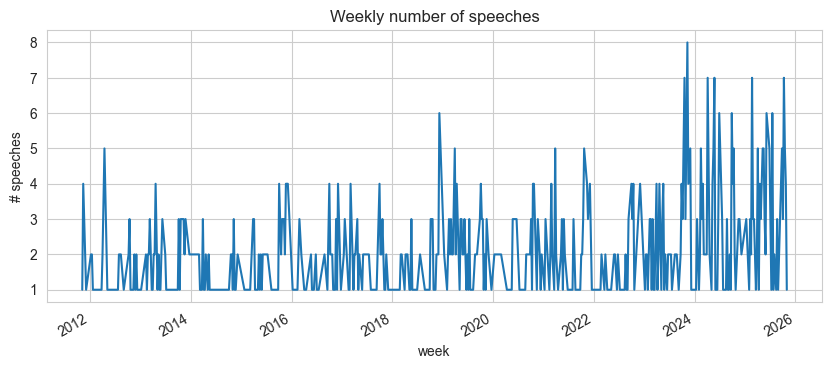

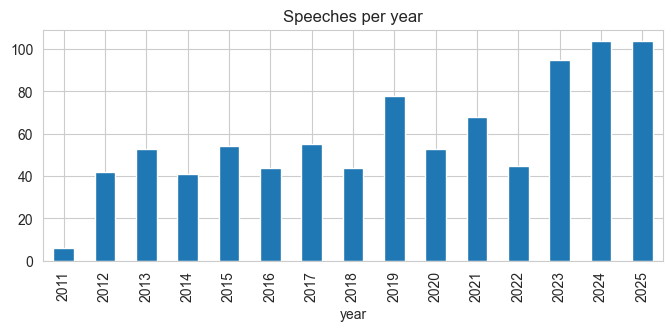

Correlation (# speeches vs avg length): r = -0.02 (p-value = 0.65)


In [89]:
# Basic yearly and speaker stats
by_year = speeches.groupby("year").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)
by_speaker = speeches.groupby("speaker").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean")
).sort_values("n_speeches", ascending=False).head(10)

print("Yearly summary:\n", by_year.tail())
print("\nTop speakers:\n", by_speaker)

# Weekly and monthly cadence
weekly = speeches.groupby("week").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

# Plots
weekly["n_speeches"].plot(figsize=(10,4), title="Weekly number of speeches", ylabel="# speeches")
plt.show()

by_year["n_speeches"].plot(kind="bar", figsize=(8,3), title="Speeches per year")
plt.show()

# Correlation check with statistical significance
corr_coef, p_value = pearsonr(weekly["n_speeches"], weekly["avg_wc"])

print(f"Correlation (# speeches vs avg length): r = {corr_coef:.2f} (p-value = {p_value:.2f})")

<u><strong>Key Observations:</strong></u>
- The number of speeches per year has increased notably, motivating our investigation into information overload.
- Communication is concentrated among a few key governors.
- The correlation between the number of weekly speeches and their average length is extremely weak (r = –0.02) and statistically insignificant (p = 0.65). This result provides no evidence that the Fed delivers shorter or more concise messages during weeks of intense communication activity. As a consequence, when communication frequency rises while average length remains stable, the total communication volume mechanically increases. This increase in volume, likely concentrated on a finite set of recurring policy themes, suggests a higher risk of message repetition and informational redundancy. 

These findings justify the need to move beyond raw frequency metrics and motivate the construction of our Communication Saturation Index (CSI), which explicitly captures semantic overlap and informational crowding

##### **Preliminary Lexical Analysis**

Before applying complex semantic models, a preliminary lexical analysis provides a foundational understanding of the corpus. The goal is to answer two key questions: What are the dominant topics in the Fed's communication? and How has the focus on these topics shifted over time? This analysis serves to validate our dataset by ensuring it reflects known macroeconomic events and provides an initial map of the topics where communication saturation is most likely to occur.

<u><strong>Methodology:</strong></u> Our approach consists of several key steps:
1. Text cleaning and tokenization: each speech is processed to create a "clean" list of meaningful words (tokens). This involves converting text to lowercase, removing all punctuation and numbers, and filtering out common English "stopwords" (e.g., 'the', 'a', 'is') which carry little analytical value. This ensures our analysis focuses on substantive terms.
2. Frequency calculation: we count the occurrences of each token. This is done both for the entire corpus (to identify globally important words) and on a year-by-year basis (to track changes).
3. Normalization for comparability: a simple word count can be misleading, as years with more speeches would naturally have higher counts for every word. To enable a fair comparison across years, we normalize the count of each word by the total number of tokens in that year. The result is a percentage (freq_pct), representing that word's share of the total discourse for a given year.
4. Selection of dynamic terms: instead of focusing on words that are always frequent, we are more interested in terms whose usage changes significantly over time. We identify these by calculating the variance of each word's frequency percentage across the years. The words with the highest variance are the most informative indicators of the Fed's shifting priorities

In [90]:
STOPWORDS = set(stopwords.words("english"))                                     # Convert everything to lowercase (case-insensitive analysis)
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r"[^a-z\s]", " ", txt)                                         # Remove punctuation, numbers, and symbols
    return [w for w in txt.split() if w not in STOPWORDS and len(w) > 2]        # Split text into individual words (“tokens”), remove useless common words (“the”, “and”, “of”…) and remove ultra-short tokens like “a”, “us”, “it”

speeches["tokens"] = speeches["text"].apply(clean_text)
speeches["year"] = speeches["date"].dt.year

# Top frequent words per year : we group all speeches from the same year, merge all their tokens and find the most common words 
def top_words_by_year(df, n=10):
    return (
        df.groupby("year")["tokens"]
          .apply(lambda x: Counter([w for tokens in x for w in tokens]).most_common(n))
    )

# Flatten yearly top words to a tidy DataFrame
records = []
top_words = top_words_by_year(speeches, n=15)
for year, lst in top_words.items():
    for word, count in lst:
        records.append((int(year), word, int(count)))

df_top = pd.DataFrame(records, columns=["year", "word", "count"]).sort_values(["year","count"], ascending=[True, False]) 

# Normalize by total tokens per year (so years are comparable)
year_totals = (
    speeches.groupby("year")["tokens"]
            .apply(lambda toks: sum(len(t) for t in toks))
            .rename("year_token_total")
)
df_top = df_top.merge(year_totals, on="year", how="left")
df_top["freq_pct"] = 100 * df_top["count"] / df_top["year_token_total"]

# Quick global word frequency: this merges all speeches together, giving the 30 most frequent words in the full dataset:
all_words = [w for tokens in speeches["tokens"] for w in tokens]
freq = Counter(all_words).most_common(30)
pd.DataFrame(freq, columns=["word", "count"]).head(10)

,word,count
0,financial,11527
1,policy,10484
2,inflation,10119
3,banks,8842
4,federal,8218
5,market,7063
6,rate,6913
7,bank,6573
8,percent,6363
9,reserve,6049


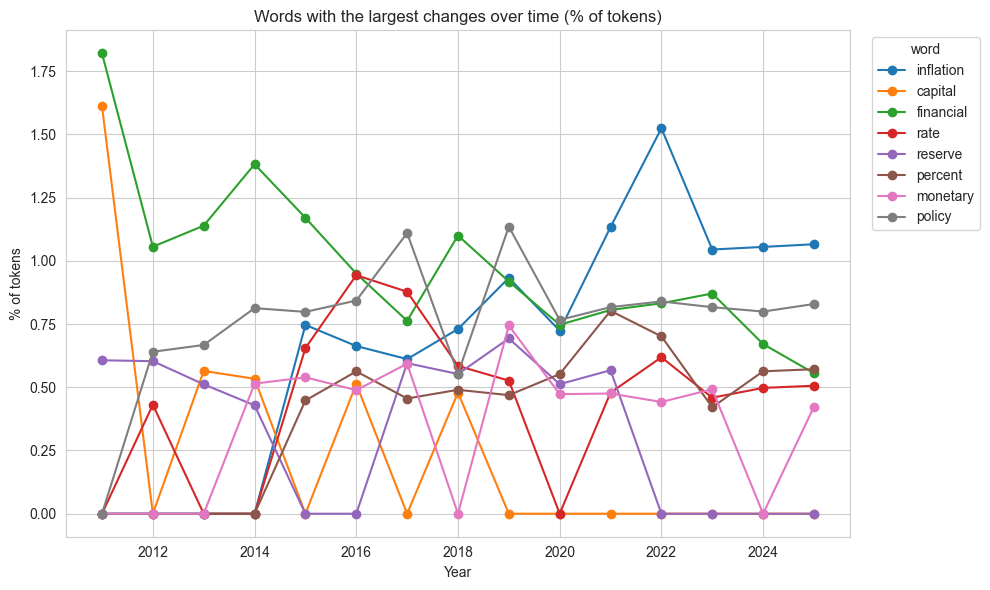

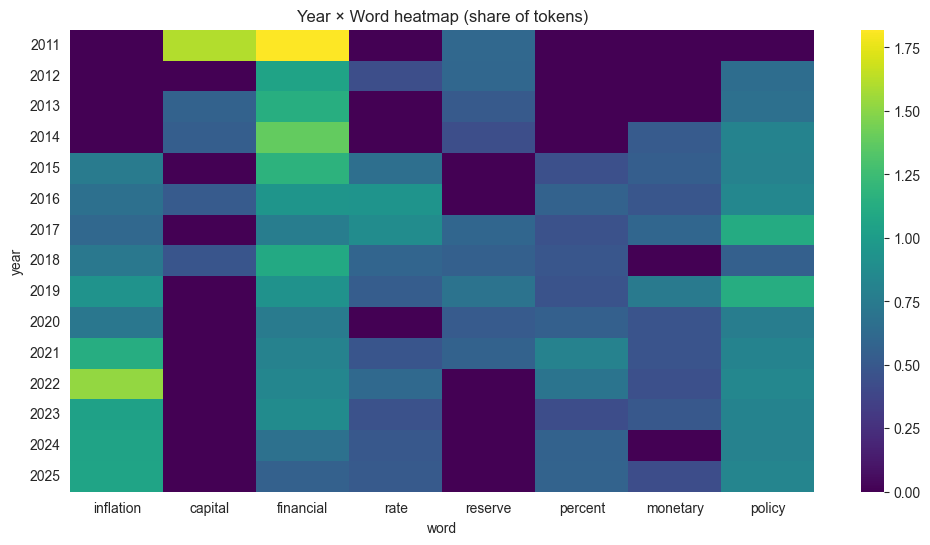

In [91]:
# Pivot to year x word matrix of % frequencies
mat = df_top.pivot_table(index="year", columns="word", values="freq_pct", fill_value=0)

# Pick words with largest variance over years
top_var_words = mat.var().sort_values(ascending=False).head(8).index.tolist()

mat[top_var_words].plot(figsize=(10,6), marker="o")
plt.title("Words with the largest changes over time (% of tokens)")
plt.xlabel("Year"); plt.ylabel("% of tokens"); plt.legend(title="word", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(mat[top_var_words], cmap="viridis")
plt.title("Year × Word heatmap (share of tokens)")
plt.xlabel("word"); plt.ylabel("year")
plt.show()

<u><strong>Key Observations:</strong></u>
- Words like "inflation," "policy," and "labor" exhibit significant temporal variance, with "inflation" becoming particularly dominant post-2021, aligning with the macroeconomic context.
- This preliminary analysis highlights the changing focus of the Fed's narrative over the years.

##### 3.2. Financial Market Dynamics

An overview of the market data provides context for the period under study. The following visualizations show the evolution and relationships of the key indices.

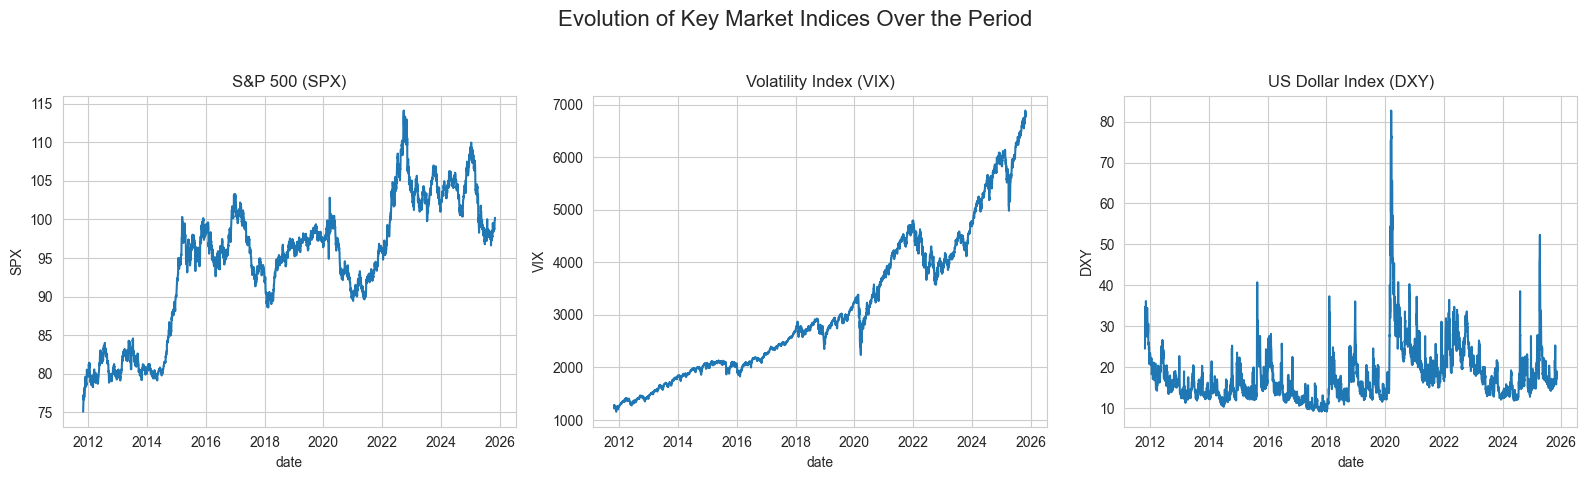

C:\Users\alexn\AppData\Local\Temp\ipykernel_14880\1858482744.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_returns = market_daily[list(tickers.keys())].pct_change().dropna()


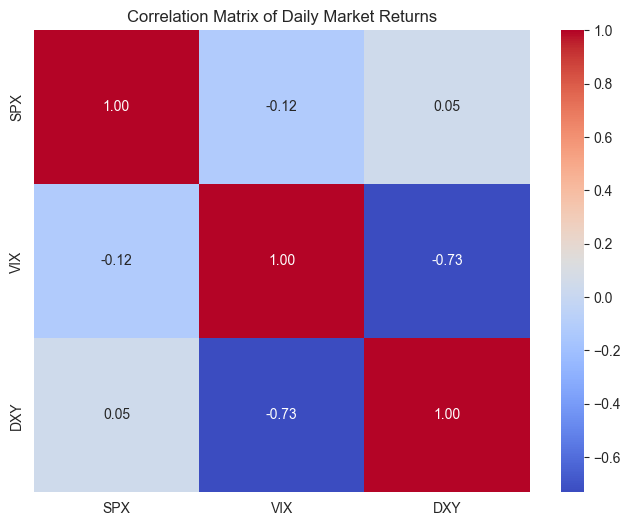

In [99]:
# Plot the evolution of the market indices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Evolution of Key Market Indices Over the Period', fontsize=16)

sns.lineplot(ax=axes[0], data=market_daily, x='date', y='SPX').set_title('S&P 500 (SPX)')
sns.lineplot(ax=axes[1], data=market_daily, x='date', y='VIX').set_title('Volatility Index (VIX)')
sns.lineplot(ax=axes[2], data=market_daily, x='date', y='DXY').set_title('US Dollar Index (DXY)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Calculate daily returns for correlation analysis
market_returns = market_daily[list(tickers.keys())].pct_change().dropna()

# Plot a correlation matrix of the daily returns
plt.figure(figsize=(8, 6))
sns.heatmap(market_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Daily Market Returns')
plt.show()

The plots above show the trajectory of the four market indices over our sample period. We can observe several market regimes, including periods of high volatility and strong trends in the equity and bond markets. This highlights the diverse market conditions in which Fed communications occurred.

The heatmap reveals the relationships between the daily movements of the indices. As expected, we observe a strong negative correlation between the SPX and the VIX, confirming the VIX's role as a 'fear gauge'. The correlations between other assets, such as the DXY and TNX, provide insights into the broader macroeconomic environment.

## <u><strong>III. Analytics and learning strategies</strong></u>

To test our hypothesis of information overload, we must first deconstruct the raw text of Fed speeches into a set of quantifiable features. This section outlines our methodology for transforming unstructured text into structured data. We proceed in three stages: first, identifying key themes and their evolution (TF-IDF and Semantic Clustering), second, quantifying the affective tone of each message (FinBERT), and finally, aggregating these features into our proposed Communication Saturation Index (CSI) and Communication Intensity Index (CII).

#### **1. Semantic and thematic analysis**

**a. Discriminative terms (TF-IDF)**

Our first analytical step is to identify the most characteristic terms of specific time periods and speakers. We use the Term Frequency-Inverse Document Frequency (TF-IDF) weighting scheme for this purpose. Unlike simple word counts, which are dominated by common words like "economy" or "policy," TF-IDF assigns a higher weight to words that are frequent within a specific document (TF) but rare across the entire corpus of speeches (IDF). This feature makes TF-IDF excellent for:
- Filtering out noise: Focusing only on terms that truly discriminate one speech from another.
- Mapping the Shifting Lexicon: By grouping speeches by year, TF-IDF reveals the evolving concerns of the Fed (e.g., from 'mortgage' in 2011 to 'crypto' in 2023).
- Speaker Profiling: Identifying the unique vocabulary of specific Governors, which is essential for understanding potential message divergence.

The analysis is based on 1-grams and 2-grams (single words and common two-word phrases) to capture basic conceptual units

In [100]:
speeches = speeches.copy()
speeches["year"] = speeches["date"].dt.year

# Build TF-IDF (1-2 grams, light pruning)
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words="english",
    ngram_range=(1,2), min_df=5, max_df=0.9
)
X = vectorizer.fit_transform(speeches["text"].fillna(""))
terms = np.array(vectorizer.get_feature_names_out())

def top_tfidf_for_groups(group_col, topk=15, min_group_size=5):
    out = {}
    for g, idx in speeches.groupby(group_col).indices.items():
        if len(idx) < min_group_size: 
            continue
        avg = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = np.argsort(avg)[::-1][:topk]
        out[g] = list(zip(terms[top_idx], avg[top_idx]))
    return out

top_by_year = top_tfidf_for_groups("year", topk=15, min_group_size=5)
top_by_speaker = top_tfidf_for_groups("speaker", topk=15, min_group_size=5)

for year, words in sorted(top_by_year.items()):
    print(f"\n{year}")
    print(", ".join([w for w, _ in words]))


2011
financial, capital, basel, firms, military, small, basel iii, iii, systemic, basel committee, economies, asian, requirements, small businesses, small business

2012
banks, financial, community, mortgage, policy, term, housing, market, community banks, recovery, economic, lending, crisis, banking, rates

2013
financial, capital, policy, banks, market, term, crisis, risk, bank, asset, community, monetary, rate, economic, purchases

2014
financial, policy, banks, community, risk, monetary, capital, crisis, monetary policy, market, firms, community banks, bank, rate, regulatory

2015
financial, inflation, policy, market, rate, banks, monetary, crisis, liquidity, monetary policy, capital, institutions, community, percent, markets

2016
rate, inflation, financial, growth, policy, percent, productivity, market, monetary, labor, monetary policy, rates, economic, capital, economy

2017
policy, rate, inflation, financial, monetary, monetary policy, rates, market, banks, economic, percent, 

In [101]:
for spk, words in list(top_by_speaker.items())[:5]:
    print(f"\n{spk}")
    print(", ".join([w for w, _ in words]))


Chair Janet L. Yellen
inflation, rate, policy, financial, labor, economic, monetary, monetary policy, economy, percent, funds rate, fomc, market, community, women

Chair Jerome H. Powell
inflation, policy, percent, economy, monetary, labor, monetary policy, economic, pandemic, fed, market, growth, labor market, rate, time

Chairman Ben S. Bernanke
financial, banks, policy, economic, community, term, monetary, crisis, rates, market, bank, economy, banking, recovery, monetary policy

Chairman Jerome H. Powell
inflation, financial, unemployment, policy, economy, rural, monetary, rate, labor, communities, monetary policy, crisis, community, fed, growth

Governor Adriana D. Kugler
inflation, labor, percent, pandemic, supply, policy, workers, prices, data, growth, economic, labor market, expectations, goods, rate


The TF-IDF results clearly illustrate the Fed's evolving narrative. The vocabulary of the post-2008 crisis era (e.g., "basel iii", "systemic" in 2011) gradually gives way to concerns about "inflation", "labor", and the "pandemic" in the 2020s. This confirms that our text data accurately captures the macroeconomic context. More importantly for our study, it reveals that the Fed's communication is concentrated on a few dominant topics at any given time, creating the ideal conditions for potential message saturation.

**b. Semantic clustering (Embeddings + K-Means)**

To move beyond word-level analysis and capture the overall meaning or semantic content of each speech, we employ a two-step clustering methodology:

1. Feature Extraction (Sentence Embeddings): We use the `all-MiniLM-L6-v2` model, a pre-trained language model, to transform each speech into a high-dimensional numerical vector, known as an embedding. Unlike TF-IDF, these embeddings capture the meaning of the text, speeches about "financial stability" will be numerically close to those about "banking regulation," even if they do not share the exact same keywords.

2. Clustering (K-Means): We then apply the K-Means algorithm to group these embeddings into **K=6 thematic clusters**. The purpose of this step is to:
- Identify Core Themes: Systematically classify the entire corpus into major, recurring topics of Fed communication.
- Measure Thematic Saturation: This grouping allows us to later quantify the risk of information overload by measuring the frequency of the same thematic cluster over short time horizons.




In [102]:
texts = speeches["text"].fillna("").tolist()

# rebuild TF-IDF if needed
if "X" not in locals() or "terms" not in locals():
    vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,2), min_df=5, max_df=0.9)
    X = vectorizer.fit_transform(texts)
    terms = np.array(vectorizer.get_feature_names_out())

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

K = 6
km = KMeans(n_clusters=K, n_init=10, random_state=42)
speeches["theme_cluster"] = km.fit_predict(emb)

def top_terms_for_cluster(cluster_id, topk=20):
    idx = speeches.index[speeches["theme_cluster"] == cluster_id].tolist()
    if not idx: return []
    avg = np.asarray(X[idx].mean(axis=0)).ravel()
    top_idx = np.argsort(avg)[::-1][:topk]
    return list(zip(terms[top_idx], avg[top_idx]))

cluster_terms = {c: top_terms_for_cluster(c, topk=20) for c in range(K)}
cluster_terms

# optional UMAP coords
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    coords_2d = reducer.fit_transform(emb)
    speeches["umap_x"] = coords_2d[:,0]
    speeches["umap_y"] = coords_2d[:,1]
except Exception:
    pass

Batches: 100%|██████████| 28/28 [00:58<00:00,  2.09s/it]
c:\Users\alexn\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [103]:
for c in sorted(cluster_terms.keys()):
    kw = ", ".join([w for w,_ in cluster_terms[c][:12]])
    print(f"Cluster {c}: {kw}")

Cluster 0: inflation, percent, labor, policy, rate, growth, monetary, market, economy, monetary policy, labor market, year
Cluster 1: inflation, policy, monetary, rate, monetary policy, percent, labor, fomc, market, economic, economy, rates
Cluster 2: community, banks, community banks, communities, cra, bank, financial, banking, small, community development, development, credit
Cluster 3: economics, women, students, inflation, economic, education, life, economy, financial, policy, labor, pandemic
Cluster 4: payments, payment, ai, cbdc, innovation, financial, digital, technology, banks, crypto, stablecoins, bank
Cluster 5: financial, capital, banks, stress, risk, liquidity, banking, regulatory, bank, firms, crisis, requirements


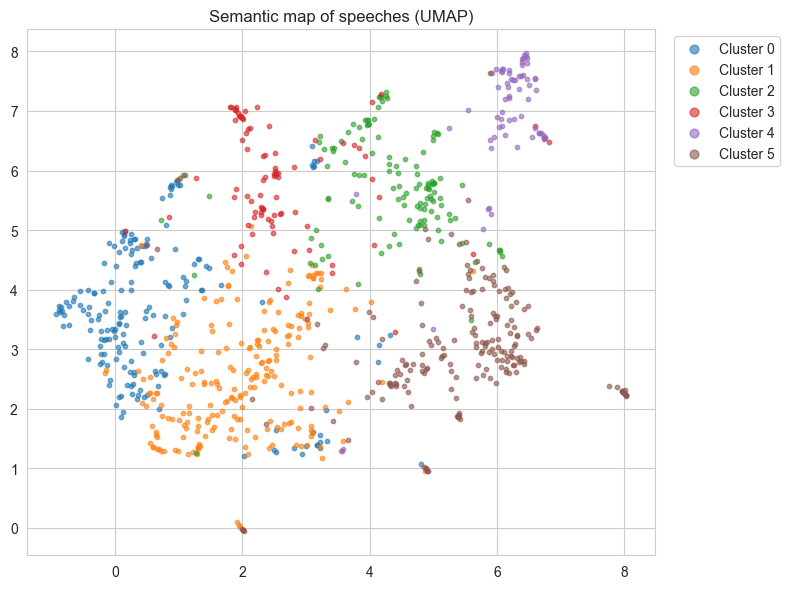

In [104]:
if {"umap_x","umap_y","theme_cluster"}.issubset(speeches.columns):
    plt.figure(figsize=(8,6))
    for c in sorted(speeches["theme_cluster"].unique()):
        m = speeches["theme_cluster"] == c
        plt.scatter(speeches.loc[m, "umap_x"], speeches.loc[m, "umap_y"], s=10, alpha=0.6, label=f"Cluster {c}")
    plt.title("Semantic map of speeches (UMAP)"); plt.legend(markerscale=2, bbox_to_anchor=(1.02,1), loc="upper left"); plt.tight_layout(); plt.show()

<u><strong>Key Observations:</strong></u>

This scatter plot displays the high-dimensional speech embeddings projected onto a 2D plane using UMAP (Uniform Manifold Approximation and Projection).
- Interpretation: Each point represents a single speech. The goal of the UMAP algorithm is to place speeches that are semantically close (i.e., discuss similar topics) near each other visually.
- Insight: The clear spatial separation of the different colored clusters (determined by K-Means) visually confirms the existence of distinct, internally coherent thematic groups within the Fed's communication. This provides confidence that our clustering accurately segments the corpus into meaningful themes.

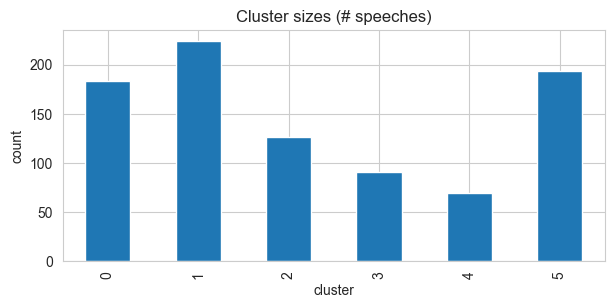

In [105]:
counts = speeches["theme_cluster"].value_counts().sort_index()
counts.plot(kind="bar", figsize=(7,3), title="Cluster sizes (# speeches)"); plt.xlabel("cluster"); plt.ylabel("count"); plt.show()

<u><strong>Key Observations:</strong></u>

This bar chart shows the total number of speeches assigned to each theme.
The significant disparity in size, where a few clusters dominate the total speech count confirms that the majority of the Fed's public communication energy is concentrated on a small set of axes.
This concentration shows that the increase in the number of speeches (from Part II) is applied to an already narrow thematic focus, creating ideal structural conditions for message saturation.

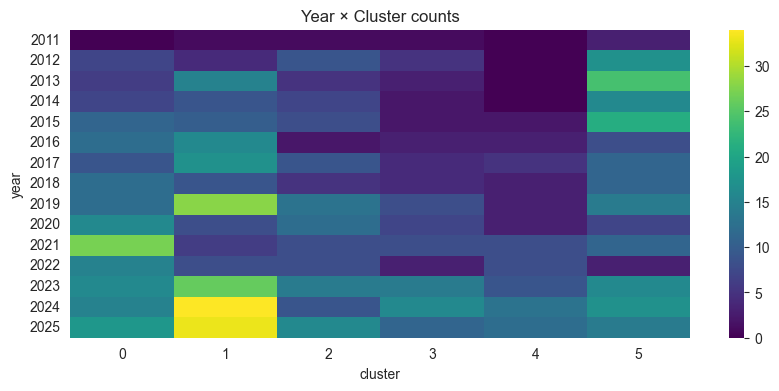

In [106]:
speeches["year"] = speeches["date"].dt.year
tab = pd.crosstab(speeches["year"], speeches["theme_cluster"])
plt.figure(figsize=(10,4)); sns.heatmap(tab, cmap="viridis"); plt.title("Year × Cluster counts"); plt.xlabel("cluster"); plt.ylabel("year"); plt.show()

<u><strong>Key Observations:</strong></u>

This heatmap illustrates how the presence of each thematic cluster evolves over the years. Brighter colors indicate a higher number of speeches on that specific topic during that year.
The heatmap highlights the impact of external events, such as the clear dominance of specific clusters during periods like the post-2021 inflation surge.
This visualization confirms that the Fed's narrative is not static. It validates the need for an event-based approach that links market reactions to the contemporary communication features (intensity, saturation, tone) prevailing at that specific time, rather than assuming a single, constant relationship over the entire decade.

#### **2. Tonal Analysis (FinBERT)**
Beyond the topic of communication, the tone is a critical channel of information. A message can be diluted not only by thematic repetition but also by tonal inconsistency or saturation. To quantify this dimension, we use FinBERT, a state-of-the-art language model specifically fine-tuned on a large corpus of financial texts. This specialization makes it superior to generic sentiment models as it understands the specific nuances of market-related language.

FinBERT classifies each speech into one of three categories, representing its likely interpretation from an investor's perspective:
- Positive: A confident, reassuring, or optimistic tone regarding the economy, growth, monetary policy, or financial stability. The text suggests favorable conditions or successful policy outcomes (e.g., "inflation is returning to our target").
- Neutral: An informative, descriptive, or factual tone, without explicit judgment or emotion. As observed in our results, this is the default stance for the majority of Fed communications, which prize objectivity.
- Negative: A worried, cautious, or pessimistic tone, signaling economic risks, headwinds, or challenges (e.g., "significant uncertainty remains about the outlook").

This tonal classification provides a feature for our final Communication Intensity Index (CII), allowing us to test whether tonal saturation or conflict contributes to information overload.

**Note:** The following cell can take a significant amount of time to execute as it applies the language model to each speech in the corpus.

In [107]:
finbert = pipeline("sentiment-analysis",
                   model="yiyanghkust/finbert-tone",
                   tokenizer="yiyanghkust/finbert-tone")

# Example: sentiment of a text by adding a sentence just to test what it returns 
finbert("Inflation pressures remain elevated while growth slows.")

Device set to use cpu


[{'label': 'Negative', 'score': 0.9999305009841919}]

Starting sentiment analysis (this may take some time)...
Sentiment analysis completed.

Enriched DataFrame successfully saved to 'speeches_with_nlp.csv'.

Preview of new columns:


,date,speaker,sentiment,tone_score
0,2011-11-04,Governor Daniel K. Tarullo,Neutral,0
1,2011-11-09,Governor Daniel K. Tarullo,Negative,-1
2,2011-11-09,Chairman Ben S. Bernanke,Neutral,0
3,2011-11-10,Chairman Ben S. Bernanke,Positive,1
4,2011-11-11,Vice Chair Janet L. Yellen,Positive,1


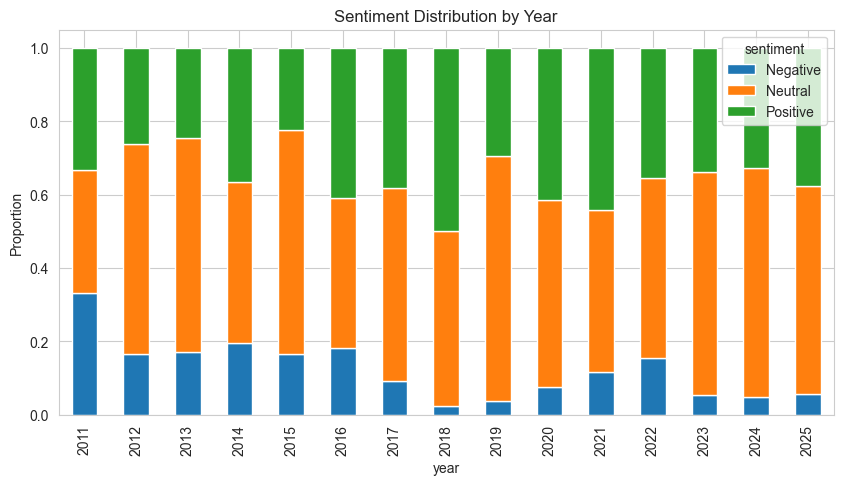

In [109]:
try:
    finbert_pipeline
except NameError:
    print("Initializing FinBERT pipeline...")
    finbert_pipeline = pipeline("sentiment-analysis",
                                model="yiyanghkust/finbert-tone",
                                tokenizer="yiyanghkust/finbert-tone")

print("Starting sentiment analysis (this may take some time)...")
if not speeches.empty:
    speeches["sentiment"] = speeches["text"].apply(lambda x: finbert_pipeline(x[:512])[0]['label'])
    print("Sentiment analysis completed.")

    sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    speeches['tone_score'] = speeches['sentiment'].map(sentiment_mapping)
    
    output_filename = "speeches_with_nlp.csv"
    speeches.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"\nEnriched DataFrame successfully saved to '{output_filename}'.")
    print("\nPreview of new columns:")
    display(speeches[['date', 'speaker', 'sentiment', 'tone_score']].head())

    sentiment_by_year = pd.crosstab(speeches["year"], speeches["sentiment"], normalize="index")
    sentiment_by_year.plot(kind="bar", stacked=True, figsize=(10, 5), title="Sentiment Distribution by Year")
    plt.ylabel("Proportion")
    plt.show()
else:
    print("The 'speeches' DataFrame is empty. Please run the data loading cells first.")

<u><strong>Key Observations:</strong></u>

The stacked bar chart reveals that Fed communication is predominantly 'Neutral', which aligns with the institution's formal and data-driven style. However, this neutrality is precisely why shifts towards 'Positive' or 'Negative' language are so significant for markets.

<u><strong>Conclusion:</strong></u>

The preceding analyses have successfully deconstructed the raw text of Fed speeches into a set of structured, quantifiable features. Our findings build a clear narrative arc:
- Descriptive Analysis revealed: "The Fed is talking more and more."
- Thematic Analysis confirmed: "And it's talking more and more about the same few core topics."

This evidence strongly supports the premise that Fed communication is susceptible to information saturation. The logical next step is therefore to quantitatively measure this redundancy and combine it with other communication metrics to build a comprehensive indicator of "information pressure". This is the objective of the Communication Saturation Index (CSI) and the Communication Intensity Index (CII) developed below.

#### **3. Communication Saturation Index (CSI) Construction**

The CSI is designed to quantify semantic redundancy in the Fed's communication. Leveraging the speech embeddings produced earlier, it measures message similarity across two complementary time axes. The calculation is based on the cosine similarity between the embedding vectors of two speeches (A and B):


$$\text{similarity}(A,B) = \cos(\theta) = \frac{A \cdot B}{\lVert A\rVert \,\lVert B\rVert}$$

This metric ranges from -1 (opposite meaning) to 1 (identical meaning), where 1 signifies perfect semantic similarity. We construct two weekly indicators:
- Intra-week Redundancy (csi_within_mean): Measures message coordination or duplication within the same week. It is the average cosine similarity across all pairs of speeches in a given week. A high score suggests a hammered, coordinated message.
- Short-term Repetition (csi_recent_maxavg): Captures the persistence or recycling of narratives. For each speech in a week, we find its closest semantic match in the preceding 8 weeks. The index is the average of these maximum similarities. A high score indicates low new information content compared to the recent past.

,csi_within_mean,csi_recent_maxavg,n_speeches
week,,,
2017-07-14,1.000000,0.554830,2
2017-02-24,NaN,0.936256,1
2015-02-06,NaN,0.905844,1
2024-08-16,NaN,0.892389,1
2016-11-04,NaN,0.855469,1
2024-05-03,NaN,0.838880,1
2021-05-14,0.699368,0.833725,3
2025-08-01,0.729393,0.831901,2
2019-05-03,NaN,0.827238,1


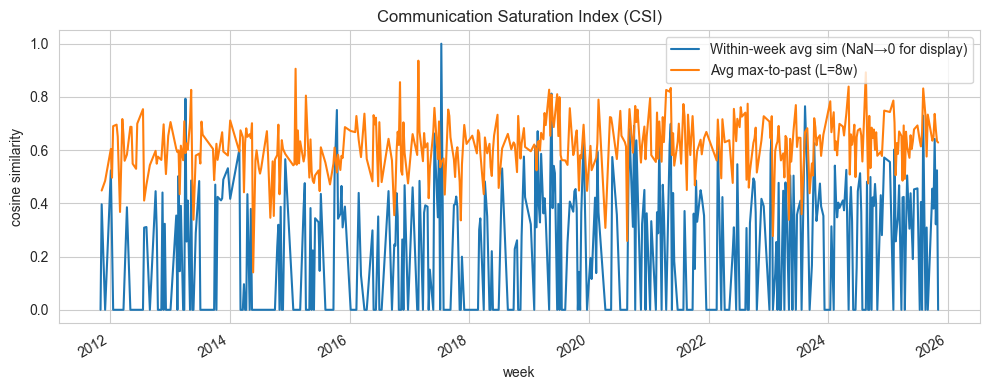

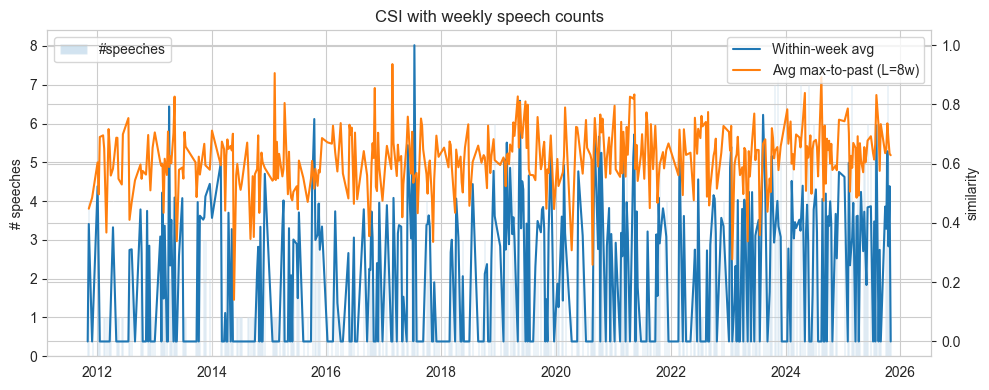

In [110]:
# Preconditions 
assert "date" in speeches.columns and "text" in speeches.columns, "speeches must have 'date' and 'text'."
speeches = speeches.sort_values("date").reset_index(drop=True)
speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

# Reuse embeddings from Part 2 if present; otherwise compute once
try:
    emb  # already in memory from Part 2
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb = model.encode(speeches["text"].fillna("").tolist(),
                       show_progress_bar=True, convert_to_numpy=True)

# Cosine similarity matrix 
emb = np.asarray(emb, dtype=float)
emb_norm = emb / np.clip(np.linalg.norm(emb, axis=1, keepdims=True), 1e-12, None)
S = (emb_norm @ emb_norm.T).astype(np.float32)
np.fill_diagonal(S, np.nan)  # ignore self-similarity

# CSI(A): within-week redundancy 
from itertools import combinations
TAU = 0.75  # near-duplicate threshold (tune if needed)

rows = []
for w, g in speeches.groupby("week", sort=True):
    idx = g.index.to_list()
    n = len(idx)
    if n < 2:
        # keep NaN in the table (truthful: not computable), but we will fill for plotting
        rows.append({"week": w, "csi_within_mean": np.nan, "csi_within_share_tau": np.nan, "n_speeches": n})
        continue
    sims = np.array([S[i, j] for i, j in combinations(idx, 2)], dtype=float)
    rows.append({
        "week": w,
        "csi_within_mean": float(np.nanmean(sims)),
        "csi_within_share_tau": float(np.mean(sims >= TAU)),
        "n_speeches": n
    })

csi_within = pd.DataFrame(rows).set_index("week").sort_index()

# CSI(B): repetition vs recent past (lookback L=8 weeks) 
L = 8  # lookback window in weeks (4–12 is typical)
week_code = pd.Categorical(speeches["week"]).codes
max_sim_past = np.full(len(speeches), np.nan, dtype=float)

for i in range(len(speeches)):
    wi = week_code[i]
    past_idx = speeches.index[(week_code < wi) & (week_code >= wi - L)]
    if len(past_idx):
        sims = S[i, past_idx]
        max_sim_past[i] = np.nanmax(sims) if np.isfinite(sims).any() else np.nan

speeches["max_sim_past"] = max_sim_past
csi_recent = (
    speeches.groupby("week")["max_sim_past"]
            .mean()
            .to_frame("csi_recent_maxavg")
            .sort_index()
)

# Final weekly CSI panel 
csi_panel = (
    csi_within
    .join(csi_recent, how="outer")
    .sort_index()
)

# A clean view for plotting (no NaNs): fill weeks with <2 speeches with 0 for the within-week line only
csi_plot = csi_panel.copy()
csi_plot["csi_within_mean_filled"] = csi_plot["csi_within_mean"].fillna(0.0)

# Minimal, useful outputs
# (a) Top-10 weeks by saturation (either metric)
rank = (
    csi_panel.assign(
        csi_rank_proxy = csi_panel[["csi_within_mean","csi_recent_maxavg"]].max(axis=1, skipna=True)
    )
    .sort_values("csi_rank_proxy", ascending=False)
    .head(10)[["csi_within_mean","csi_recent_maxavg","n_speeches"]]
)
display(rank)

# (b) Quick lines + counts
import matplotlib.pyplot as plt

ax = csi_plot[["csi_within_mean_filled","csi_recent_maxavg"]].plot(
    figsize=(10,4), ylabel="cosine similarity",
    title="Communication Saturation Index (CSI)"
)
ax.legend(["Within-week avg sim (NaN→0 for display)","Avg max-to-past (L=8w)"])
plt.tight_layout(); plt.show()

# bars for weekly #speeches + lines
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.bar(csi_panel.index, csi_panel["n_speeches"].fillna(0), width=6, alpha=0.2, label="#speeches")
ax2 = ax1.twinx()
ax2.plot(csi_plot.index, csi_plot["csi_within_mean_filled"], label="Within-week avg", lw=1.5)
ax2.plot(csi_plot.index, csi_plot["csi_recent_maxavg"], label="Avg max-to-past (L=8w)", lw=1.5)
ax1.set_title("CSI with weekly speech counts")
ax1.set_ylabel("# speeches"); ax2.set_ylabel("similarity")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()

# (c) Save for Part 4 (CII)
csi_panel.to_csv("csi_weekly.csv")

<u><strong>Key Observations of CSI results:</strong></u>

Table: Weeks with Highest Saturation
The table highlights specific weeks of extreme communication saturation.
- Weeks with a csi_within_mean near 1.0 indicate a highly coordinated, unified message delivered by multiple speakers, likely during critical policy announcements (e.g., FOMC meetings).
- High csi_recent_maxavg values, even for weeks with only one speech, reveal a strong narrative continuity, where the current message is essentially a repetition of recent communications. These peaks demonstrate that our index successfully captures periods of deliberate message hammering.

Graph 1: CSI Components Over Time
This plot reveals the two distinct dynamics of saturation:
- The orange line (past repetition) is structurally high (around 0.6-0.7), confirming that the Fed's discourse is inherently continuous and relies on a standardized institutional narrative. This is the baseline level of saturation.
- The blue line (intra-week redundancy) is highly volatile and acts as a "shock" indicator. It spikes only during weeks with multiple speeches, signaling a tactical effort to coordinate the message across different speakers.

Graph 2: CSI with Weekly Speech Counts
This graph provides the most compelling visual evidence for our hypothesis.
- There is a clear visual correlation between the height of the bars (high speech frequency) and the spikes in the blue line (high intra-week redundancy).
- This directly confirms our finding from Part II: weeks with intense communication are not delivering more diverse information, but are instead characterized by greater message repetition. The Fed doesn't just talk more; it says the same thing more often.

Conclusion on CSI:
The CSI successfully quantifies the high degree of homogeneity and repetition in the Fed's communication. It distinguishes between the strategic, long-term narrative consistency and the tactical, short-term message coordination. This index now provides a crucial "redundancy" feature for our final, more comprehensive Communication Intensity Index (CII).

#### **4. Communication Intensity Index (CII) construction**

The CII is our final synthetic indicator, designed to aggregate multiple facets of Federal Reserve communication into a single weekly measure of information pressure. It combines the following dimensions:
1. Quantitative Dimension
- Frequency (n_speeches)
- Length (mean_wordcount)
- Speaker diversity (n_speakers)
2. Redundancy Dimension (via the CSI)
- Within-week saturation (csi_within_mean)
- Recent repetition (csi_recent_maxavg)

<u><strong>Methodology</strong></u>
- Feature Selection:
we select the core variables that represent distinct dimensions of communication volume and redundancy.
- Normalization (Z-scores):
each variable is transformed into a standardized z-score to ensure comparability across different scales and units.
The formula is:

$$z_i = \frac{x_i - \bar{x}}{\sigma_x}$$
- Aggregation (PCA):
to combine the standardized metrics optimally, we apply Principal Component Analysis (PCA).
The CII is defined as the first principal component, which captures the largest share of the joint variance across all indicators.
This approach is more robust than a simple average because it weights each component according to its contribution to the overall communication dynamics.

In [111]:
# Load or rebuild minimal inputs for the CII 

# Communication metrics (panel_weekly)

speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
panel_weekly = (
    speeches.groupby("week")
            .agg(n_speeches=("text","count"),
                 sum_wordcount=("word_count","sum"),
                 mean_wordcount=("word_count","mean"),
                 n_speakers=("speaker", lambda s: s.nunique()))
            .sort_index()
)

# Tone metrics (nlp_weekly)
try:
    nlp_weekly = pd.read_csv("speeches_with_nlp.csv", parse_dates=["date"])
    nlp_weekly["week"] = nlp_weekly["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
    nlp_weekly = (
        nlp_weekly.groupby("week")
                  .agg(tone_score_w=("tone_score", "mean"))
                  .sort_index()
    )
except Exception:
    print("Tone file not found; tone_score_w will be NaN")
    nlp_weekly = pd.DataFrame(columns=["tone_score_w"])

# Redundancy metrics (csi_panel)
try:
    csi_panel = pd.read_csv("csi_weekly.csv", parse_dates=["week"]).set_index("week")
except Exception:
    print("CSI file not found; you can rerun Part 3 if needed")
    csi_panel = pd.DataFrame(columns=["csi_within_mean","csi_recent_maxavg"])

Explained variance (1st component): 0.423


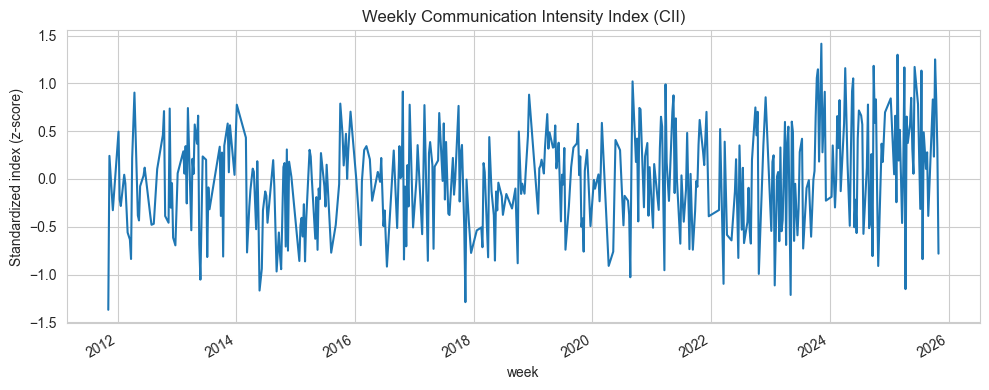

In [ ]:
# Clean merge
cii_base = (
    panel_weekly
    .join(nlp_weekly[["tone_score_w"]], how="left")
    .join(csi_panel[["csi_within_mean","csi_recent_maxavg"]], how="left")
    .fillna(0)
)

cii_base['tone_intensity'] = cii_base['tone_score_w'].abs()

# Select CII components
features = [
    "n_speeches", "mean_wordcount", "n_speakers",      # Quantitative
    "csi_within_mean", "csi_recent_maxavg",            # Redundancy
    "tone_intensity"                                   # Tonal
]

cii = cii_base[features].copy()

# Standardization (z-scores) 
scaler = StandardScaler()
cii_z = pd.DataFrame(
    scaler.fit_transform(cii),
    index=cii.index,
    columns=[f"{c}_z" for c in cii.columns]
)

# Simple aggregation (overall CII)
cii_z["CII"] = cii_z.mean(axis=1)

# Option: weighting via PCA (more robust)
try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    cii_z["CII_pca"] = pca.fit_transform(cii_z[cii_z.columns[:-1]])
    print("Explained variance (1st component):", round(pca.explained_variance_ratio_[0],3))
except Exception as e:
    print("PCA not available, fallback to simple mean:", e)

# Visualization
plt.figure(figsize=(10,4))
cii_z["CII"].plot(title="Weekly Communication Intensity Index (CII)")
plt.ylabel("Standardized index (z-score)")
plt.tight_layout()
plt.show()

# Export for Part 5
cii_z.to_csv("cii_weekly.csv")

<u><strong>Key Observations of the CII Graph:</strong></u>

The resulting time-series plot shows the evolution of the Weekly Communication Intensity.
- High CII (Positive values): Represents weeks of intense communication pressure. These are periods with numerous, lengthy, and highly repetitive speeches, indicating a strong effort from the Fed to saturate the information space.
- Low CII (Negative values): Represents calmer periods with fewer, shorter, or more novel communications.

This final CII is the key indicator we will use in the next section to test our central hypothesis.

## <u><strong>IV. Empirical results: baseline and robustness</strong></u>

This section links our communication indicators, developed in the previous section, to the market data we have gathered.

#### **1. Data alignment and market reaction calculation**

We begin by calculating the forward-looking market returns, which will serve as our target variables. We compute percentage changes over 1, 2, and 3-day horizons for each market index. These horizons allow us to capture the immediate and near-term reactions to Fed communications.


In [114]:
# NOTE: The 'market_daily' DataFrame is already loaded from Part II.
# We now calculate the forward returns on it.
for col in ["SPX","VIX","DXY"]:
    for horizon in [1,2,3]:
        market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)


C:\Users\alexn\AppData\Local\Temp\ipykernel_14880\3374469343.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)
C:\Users\alexn\AppData\Local\Temp\ipykernel_14880\3374469343.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)
C:\Users\alexn\AppData\Local\Temp\ipykernel_14880\3374469343.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be r

In [115]:
# Merge
df_merge = speeches.merge(cii_z.reset_index()[['week','n_speeches_z', 'mean_wordcount_z', 'n_speakers_z', 'CII','csi_within_mean_z','csi_recent_maxavg_z']], on='week', how='left')

We merge the market data with our speech dataset (df_merge), aligning on the dates when speeches occurred and we compute forward returns for each market variable over 1, 2, and 3-day horizons, providing short-term measures of market response that can be linked to the characteristics of the speeches.

In [116]:
# Merge par nearest date backward
df_merge['date'] = pd.to_datetime(df_merge['date'])

df_merge = pd.merge_asof(
    df_merge.sort_values('date'),
    market_daily[['date'] + [f"{col}_chg_{h}d" for col in ["SPX","VIX","DXY"] for h in [1,2,3]]].sort_values('date'),
    left_on='date',
    right_on='date',
    direction='backward'
)

#### **2. Baseline results**

**a. Visual analysis**

The first step in our analysis is to visually inspect whether there is any discernible pattern between the CII values and market movements, also taking into account sentiment. While plotting these relationships can provide an initial sense of trends, it quickly becomes apparent that identifying clear patterns is challenging. This is partly because market movements are influenced by numerous factors beyond just speeches. Nevertheless, the subsequent analysis will focus on studying the correlations between market returns and the individual features underlying the CII, in order to assess whether these relationships are statistically significant.

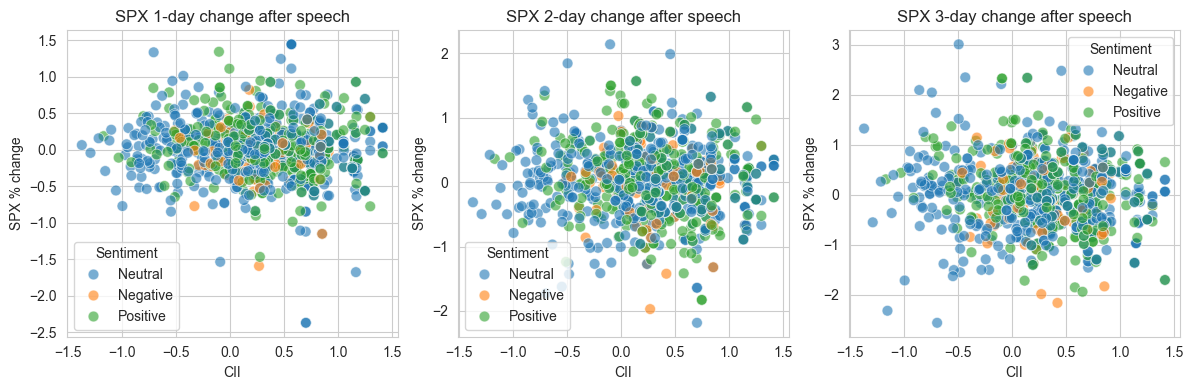

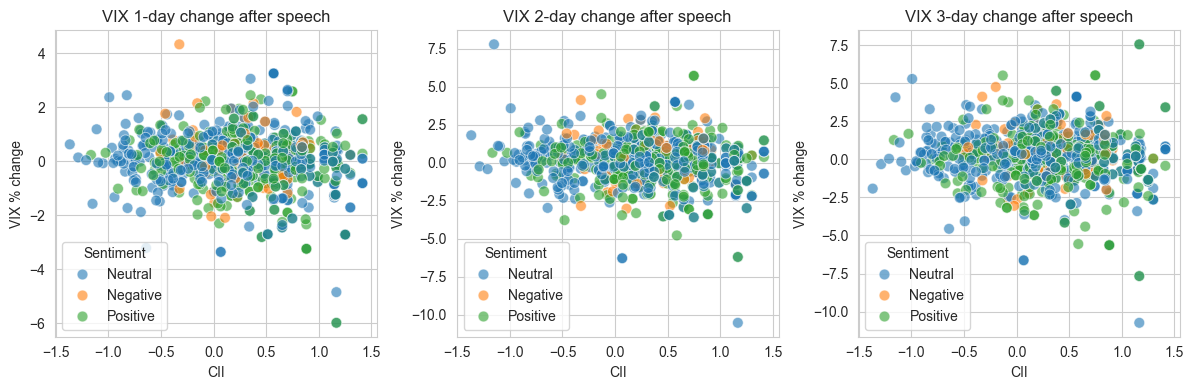

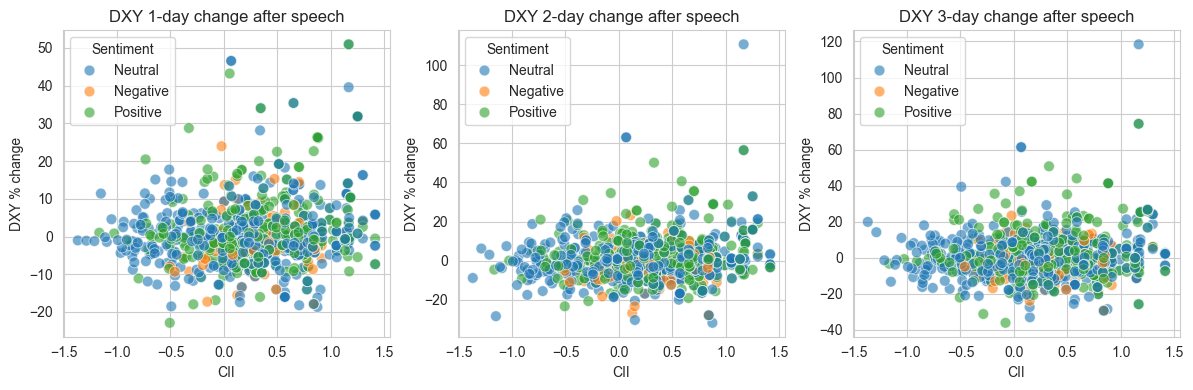

In [117]:
market_vars = ["SPX", "VIX", "DXY"]
horizons = [1, 2, 3]

for m in market_vars:
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(horizons, 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(
            x="CII",    
            hue="sentiment",          
            y=f"{m}_chg_{h}d",
            data=df_merge,
            s=60, alpha=0.6
        )
        plt.title(f"{m} {h}-day change after speech")
        plt.xlabel("CII")
        plt.ylabel(f"{m} % change")
        plt.legend(title="Sentiment", loc="best")
    plt.tight_layout()
    plt.show()

Next, we examine boxplots of market variations as a function of the CII. We observe that the variance tends to be slightly higher when the CII is elevated, but a statistical approach is required to quantify this effect. It is important to note that the CII was constructed as the sum of several normalized variables; however, weighting these variables according to their potential impact could provide a more accurate measure. In any case, we expect a substantial amount of noise, so while one might anticipate seeing the influence of the CII visually, it may be more reliably captured through statistical analysis rather than through plots alone. Here, we focus specifically on boxplots of VIX changes relative to the CII.

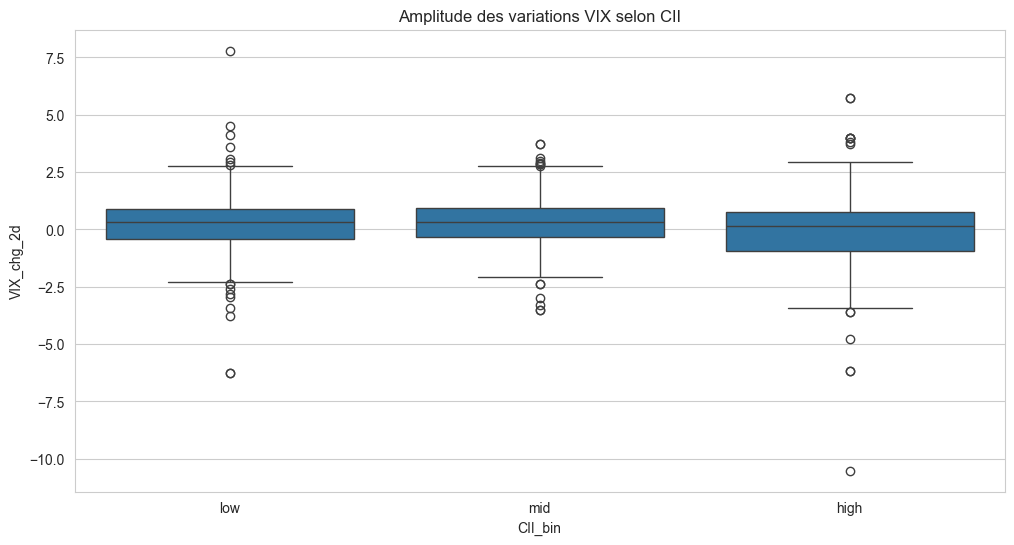

In [118]:
df_merge["CII_bin"] = pd.qcut(df_merge["CII"], q=3, labels=["low","mid","high"])

sns.boxplot(data=df_merge, x="CII_bin", y="VIX_chg_2d")
plt.title("Amplitude des variations VIX selon CII")
plt.show()

**b. Correlation and statistical significance**

We next compute the correlations between the previously constructed CII and the market returns. To quantify the statistical significance of these correlations, we use the pearsonr function from the scipy.stats module, which provides both the correlation coefficient and its associated p-value. While the observed correlation values are generally low, most of them are statistically significant, indicating that despite the weak linear relationship, the CII does capture some measurable signal related to short-term market movements.

We observe a negative correlation between S&P 500 (SPX) returns, VIX returns and the CII, suggesting that higher communication activity tends to coincide with downward pressure on equity markets and volatility. Conversely, there are positive correlations with DXY, indicating that increased speech intensity is associated with a stronger US dollar (DXY).

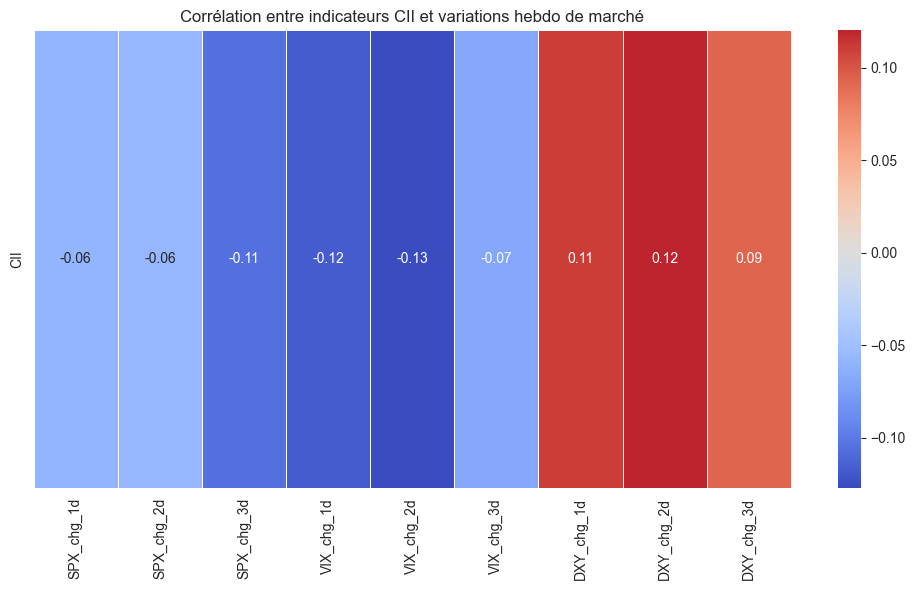

In [133]:
features = ["CII"]

market_cols = ["SPX_chg_1d","SPX_chg_2d","SPX_chg_3d",
               "VIX_chg_1d","VIX_chg_2d","VIX_chg_3d",
               "DXY_chg_1d","DXY_chg_2d","DXY_chg_3d"]

corr_matrix = df_merge[features + market_cols].corr().loc[features, market_cols]

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0,fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre indicateurs CII et variations hebdo de marché")
plt.tight_layout()
plt.show()




In [134]:
results = []
for f in features:
    for m in market_cols:
        corr, pval = pearsonr(df_merge[f], df_merge[m])
        results.append([f, m, corr, pval])

df_corr = pd.DataFrame(results, columns=["Feature","Market","Corr","p_value"])
print(df_corr.sort_values("p_value"))

  Feature      Market      Corr   p_value
4     CII  VIX_chg_2d -0.127434  0.000143
7     CII  DXY_chg_2d  0.120237  0.000335
3     CII  VIX_chg_1d -0.117698  0.000447
6     CII  DXY_chg_1d  0.111140  0.000920
2     CII  SPX_chg_3d -0.106045  0.001572
8     CII  DXY_chg_3d  0.092252  0.005997
5     CII  VIX_chg_3d -0.069822  0.037719
0     CII  SPX_chg_1d -0.059648  0.075975
1     CII  SPX_chg_2d -0.057083  0.089486


#### **3. Linear regression**

In this analysis, we focus on the individual features that compose the Composite Indicator of Influence (CII) to determine appropriate weights for each component. To ensure robustness and avoid overfitting, the dataset is split into training and test sets. On the training set, we estimate linear regression coefficients for each feature and calculate their statistical significance through t‑tests and p‑values, providing insight into which speech-related characteristics meaningfully affect market movements. On the test set, we use the pre‑constructed, weighted CII to calculate its correlation with realized market changes, which allows us to evaluate how well the aggregated indicator reflects market behavior out-of-sample. For example, for the VIX 1-day change, the number of speeches shows a significant effect; after normalization, the coefficient is negative, but in terms of the original scale this corresponds to a positive influence on VIX, while the number of speakers also has a significant positive effect. Other features are not statistically significant. The correlation between the weighted CII and the actual VIX change on the test set is moderate (≈0.098), illustrating that this approach provides a coherent and statistically informed framework for allocating weights across features while maintaining predictive validity.

In [142]:
features = ["n_speeches_z", "mean_wordcount_z", "n_speakers_z",
            "csi_within_mean_z", "csi_recent_maxavg_z", "tone_score"]


market_cols = ["VIX_chg_2d"]

# Split train/test

train, test = train_test_split(df_merge, test_size=0.3, shuffle=False)

results_dict = {}
for mkt in market_cols:
    X_train = sm.add_constant(train[features])
    y_train = train[mkt]

    # Régression OLS
    model = sm.OLS(y_train, X_train).fit()
    results_dict[mkt] = model

    print(f"=== {mkt} ===")
    print(model.summary())
    print("\n")

    # Weighted CII on the test set
    X_test = sm.add_constant(test[features])
    test[f"CII_weighted_{mkt}"] = model.predict(X_test)

    # Correlation weighted CII vs market on test set
    corr = test[f"CII_weighted_{mkt}"].corr(test[mkt])
    print(f"Corrélation pondéré CII vs {mkt} sur test set: {corr:.3f}\n")

=== VIX_chg_2d ===
                            OLS Regression Results                            
Dep. Variable:             VIX_chg_2d   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.808
Date:              jeu., 13 nov. 2025   Prob (F-statistic):             0.0106
Time:                        19:48:37   Log-Likelihood:                -1064.8
No. Observations:                 620   AIC:                             2144.
Df Residuals:                     613   BIC:                             2175.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const          

The analysis indicates that the most influential variables in explaining short-term VIX movements are the number of speeches, the number of speakers and the tone score. They show statistically significant effects, suggesting that the market reacts to the quantity of communication rather than its redundancy. In contrast, the CSI-related variables are not significant, implying that repeated or highly similar content does not trigger notable market responses. Overall, while the correlations remain relatively low, these findings highlight that certain features of speeches carry measurable information for market volatility.

## <u><strong>V. Conclusion</strong></u>

This project developed a systematic NLP and machine learning framework to quantify the intensity and redundancy of Federal Reserve communications. Using FinBERT for sentiment analysis and SentenceTransformers for semantic embeddings, we constructed two complementary indices: the Communication Intensity Index (CII) and the Communication Saturation Index (CSI). These indicators were then tested against short-term market movements through regression models divided into training and testing sets, allowing us to evaluate the strength and stability of their relationships with financial variables.

Our results show that the number of speeches, the number of speakers, and the tone of communication have a measurable influence on market reactions. Periods of high communication intensity tend to be followed by slightly negative equity returns (SPX), while the US Dollar Index (DXY) generally increase, consistent with a risk-off market environment. However, when the level of redundancy in communication is high, market sensitivity appears to weaken. This suggests that when messages become repetitive or overly coordinated, they convey limited new information to investors, leading to a muted reaction.

Although the approach provides meaningful insights, several limitations should be acknowledged. The analysis remains correlational, and market behavior is affected by many external factors such as macroeconomic releases and geopolitical developments, which were not controlled for. Moreover, FinBERT’s token limit restricted sentiment analysis to the first 512 tokens of each speech, potentially omitting relevant sections. The embedding-based similarity measures, while effective, may also miss subtler rhetorical nuances. Finally, the use of linear regression models may not fully capture non-linear or interaction effects between communication variables and market responses.

Future work could address these limitations through more causal or non-linear frameworks. An econometric perspective treating each speech as a potential treatment would allow a more rigorous estimation of its impact using causal inference techniques. Alternatively, more advanced machine learning models could be trained to predict or explain semantic redundancy, potentially uncovering when repeated communication loses market relevance. Extending the analysis to other central banks, such as the ECB or the Bank of England, could also provide a comparative view of how different communication styles influence financial markets.

Overall, this project demonstrates the relevance of combining NLP-based embeddings, sentiment analysis, and regression modeling to study central bank communication. The findings highlight that while tone and message intensity can influence markets, redundancy reduces their informational value. This framework offers a reproducible foundation for future research seeking to understand how language, information saturation, and market perception interact in shaping financial dynamics.
